In [1]:
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import torch
from sklearn.utils.class_weight import compute_class_weight


# Importing libraries
import copy
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import seaborn as sns               # For plotting the confusion matrix heatmap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

BASE_PATH = 'drive/MyDrive/NLP_project/'
# BASE_PATH = './'
if not os.path.exists(BASE_PATH):
    raise ValueError('path does not exist')

In [4]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


# Define Base Model

In [6]:
class MyBaseModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.accuracy_train_history = []
        self.accuracy_test_history = []
        self.loss_train_history = []
        self.loss_test_history = []
        self.train_time = 0

    def save(self, path):
        torch.save(self, path)

    @staticmethod
    def load(path) -> nn.Module|None:
        model = None
        if os.path.exists(path):
            print(f'Loading from disc: {path}')
            model = torch.load(path, weights_only=False)
            model.eval()
        else:
            print('Model not found!')
        return model

# Implement functions

- accuracy
- train
- validation
- top level function for training
- plot

In [7]:
def confusion(model, x, y):
    confusion_matrix = torch.zeros([10, 10]).type(torch.int32)
    true = y.argmax(dim=1).cpu()
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        pred = model(x)
    predicted = pred.argmax(dim=1).cpu()
    for i in range(true.shape[0]):
        confusion_matrix[true[i], predicted[i]] += 1
    return confusion_matrix

In [8]:
def accuracy(pred, y):
    correct = (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.int8).sum().item()
    return correct / y.shape[0] # average

In [9]:
def train(model, x, y, loss_fn, optimizer):
    model.train()

    # Loop over batches
    for i in range(x.shape[0]):
        # Forward pass and loss calculation
        pred = model(x[i])
        loss = loss_fn(pred, y[i])

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [10]:
def validation(model, x, y, loss_fn):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        pred = model(x)
        loss = loss_fn(pred, y).item()
    return pred, loss

In [11]:
def top_level_func_training(model,
                            x_train_tensor,
                            y_train_tensor,
                            x_train_batch,
                            y_train_batch,
                            x_test,
                            y_test,
                            loss_fn,
                            optimizer,
                            MODEL_PATH,
                            number_epochs=0,
                            patience=10,
                            save=True):
    # Initialize Variables for EarlyStopping
    best_loss = model.loss_test_history[-1] if len(model.loss_test_history) else float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())
    input_patience = patience

    start_time = time.time()
    # Training Loop with Early Stopping:
    for epoch in tqdm(range(number_epochs)):
        # Train
        train(model, x_train_batch, y_train_batch, loss_fn, optimizer)

        # Validation
        val_pred, val_loss = validation(model, x_test, y_test, loss_fn)
        train_pred, train_loss = validation(model, x_train_tensor, y_train_tensor, loss_fn)

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here
            patience = input_patience  # Reset patience counter
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping...')
                break

        # Save accuracy and loss on test
        model.accuracy_test_history.append(accuracy(val_pred, y_test))
        model.loss_test_history.append(val_loss)

        # Save accuracy and loss on train
        model.accuracy_train_history.append(accuracy(train_pred, y_train_tensor))
        model.loss_train_history.append(train_loss)

    end_time = time.time()
    model.train_time += (end_time - start_time)
    # Load the best model weights then save on disc
    model.load_state_dict(best_model_weights)
    model.confusion_matrix = confusion(model, x_test, y_test)
    if save:
        model.save(MODEL_PATH)

In [12]:
def plot(model):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(model.accuracy_train_history)), np.array(model.accuracy_train_history) * 100, label='Train')
    plt.plot(np.arange(len(model.accuracy_test_history)), np.array(model.accuracy_test_history) * 100, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy (batch size=100)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(model.loss_train_history)), np.array(model.loss_train_history), label='Train')
    plt.plot(np.arange(len(model.loss_test_history)), np.array(model.loss_test_history), label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss (batch size=100)')
    plt.legend()
    plt.grid()
    plt.show()
    print(f'best loss on test dataset = {model.loss_test_history[-1]:.4f}')
    print(f'best loss on train dataset = {model.loss_train_history[-1]:.4f}')
    print(f'best accuracy on test dataset = {model.accuracy_test_history[-1] * 100}%')
    print(f'train time = {model.train_time}')

# Prepare data



In [13]:
x_train_tensor = torch.load(BASE_PATH + 'tensors/x_train_tensor.pt', weights_only=False)
y_train_tensor = torch.load(BASE_PATH + 'tensors/y_train_tensor.pt', weights_only=False)
x_test_tensor = torch.load(BASE_PATH + 'tensors/x_test_tensor.pt', weights_only=False)
y_test_tensor = torch.load(BASE_PATH + 'tensors/y_test_tensor.pt', weights_only=False)

In [14]:
class_names = list(pd.read_csv(BASE_PATH + 'datasets/EmoVal.csv').drop(axis=1, columns=['Unnamed: 0', 'text']).columns)
print(class_names)

['praise', 'amusement', 'anger', 'disapproval', 'confusion', 'interest', 'sadness', 'fear', 'joy', 'love']


In [15]:
x_train_tensor = x_train_tensor[:x_train_tensor.shape[0] - x_train_tensor.shape[0]%100]
y_train_tensor = y_train_tensor[:y_train_tensor.shape[0] - y_train_tensor.shape[0]%100]

## Class weights for balancing

In [16]:
labels = y_train_tensor.argmax(dim=1)
class_weights = compute_class_weight('balanced', classes=np.arange(10), y=np.array(labels))

# Convert to PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float16, device=device)

print(class_weights_tensor)

tensor([0.5747, 1.5830, 1.0820, 1.5674, 0.3113, 2.0918, 1.6104, 6.5820, 1.1934,
        1.3057], device='cuda:0', dtype=torch.float16)


## Create Mini-batch

In [17]:
print(x_train_tensor.shape)
print(y_train_tensor.shape)
print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([189200, 10000])
torch.Size([189200, 10])
torch.Size([10562, 10000])
torch.Size([10562, 10])


In [18]:
batch_size = 100
x_train_batch = x_train_tensor.reshape(-1, batch_size, x_train_tensor.shape[1])
y_train_batch = y_train_tensor.reshape(-1, batch_size, y_train_tensor.shape[1])

In [19]:
print(x_train_batch.shape)
print(y_train_batch.shape)

torch.Size([1892, 100, 10000])
torch.Size([1892, 100, 10])


## Move to GPU

In [20]:
x_train_batch = x_train_batch.to(device)
y_train_batch = y_train_batch.to(device)
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# Define neural network model

In [21]:
features = x_train_batch.shape[2]

class NeuralNetwork1(MyBaseModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(features, features*2//3),
            nn.ReLU(),
            nn.Linear(features*2//3, features*2//3//2),
            nn.ReLU(),
            nn.Linear(features*2//3//2, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

# Train the model

## Model 1

Dataset shape: (100_000, 17_000)

Removed one time and two times words

In [22]:
MODEL_PATH = BASE_PATH + 'models/nlp_model1.pt'
model = NeuralNetwork1.load(MODEL_PATH)
if not model:
    model = NeuralNetwork1()
model = model.to(device)
model = model.type(torch.float16)

Loading from disc: drive/MyDrive/NLP_project/models/nlp_model1.pt


In [23]:
%%skip
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
top_level_func_training(model,
                        x_train_batch,
                        y_train_batch,
                        x_test_tensor,
                        y_test_tensor,
                        loss_fn,
                        optimizer,
                        MODEL_PATH,
                        number_epochs=0,
                        patience=20)

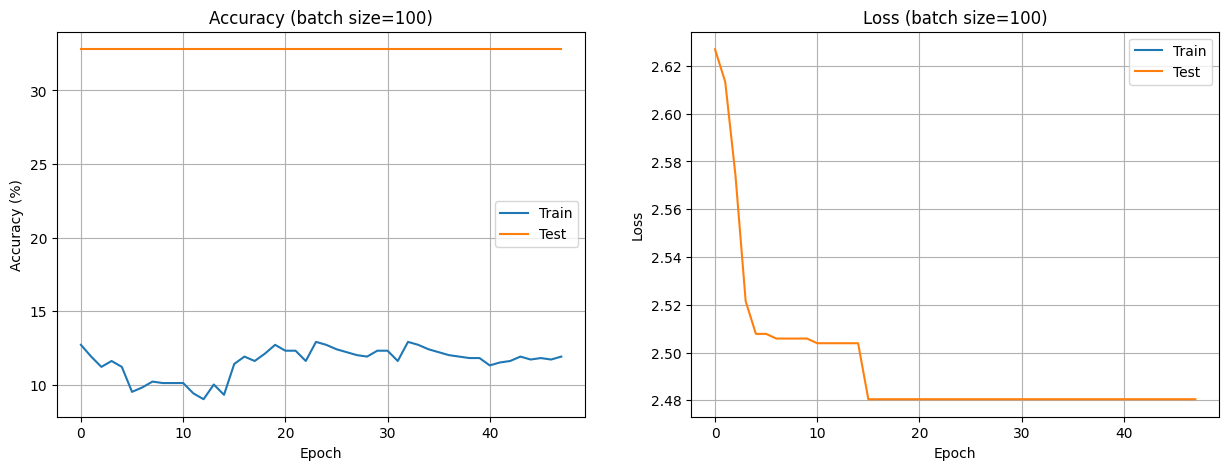

best loss on test dataset = 2.4805
best loss on train dataset = inf
best accuracy on test dataset = 32.80628668812725%
train time = 2050.7365429401398


In [24]:
plot(model)

## Model 2

Dataset shape: (190_000, 1000)

top 1000 words

In [25]:
MODEL_PATH = BASE_PATH + 'models/nlp_model2.pt'
model = NeuralNetwork1.load(MODEL_PATH)
if not model:
    model = NeuralNetwork1()
model = model.to(device)
model = model.type(torch.float16)

Loading from disc: drive/MyDrive/NLP_project/models/nlp_model2.pt


In [26]:
model

NeuralNetwork1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1000, out_features=666, bias=True)
    (1): ReLU()
    (2): Linear(in_features=666, out_features=333, bias=True)
    (3): ReLU()
    (4): Linear(in_features=333, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [27]:
%%skip
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
top_level_func_training(model,
                        x_train_batch,
                        y_train_batch,
                        x_test_tensor,
                        y_test_tensor,
                        loss_fn,
                        optimizer,
                        MODEL_PATH,
                        number_epochs=0,
                        patience=90)

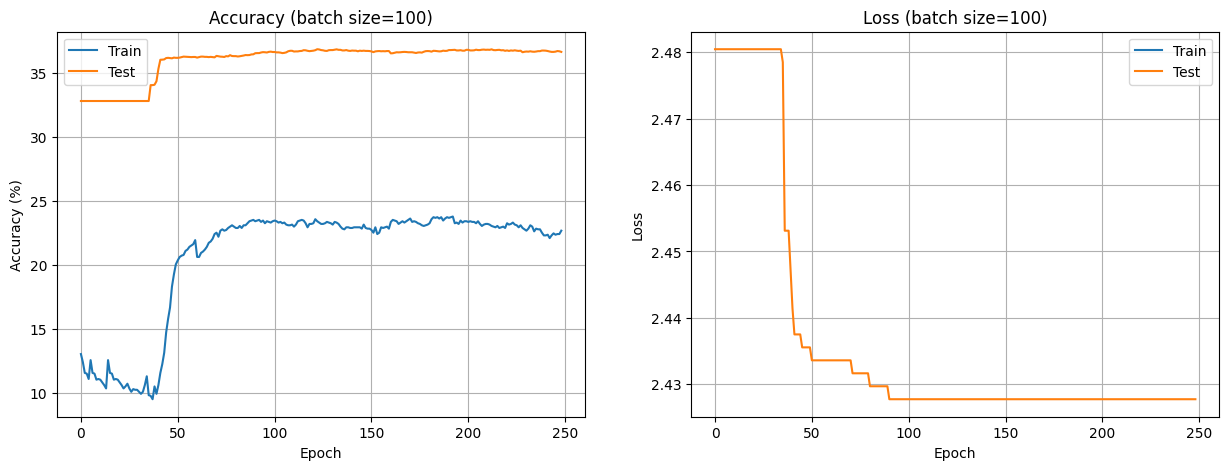

best loss on test dataset = 2.4277
best loss on train dataset = inf
best accuracy on test dataset = 36.64078772959667%
train time = 685.0907182693481


In [28]:
plot(model)

In [29]:
def plot_confusion(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.xticks(np.arange(10) + 0.5, class_names, rotation=45)
    plt.yticks(np.arange(10) + 0.5, class_names, rotation=45)
    plt.show()

In [30]:
def precision(confusion_matrix):
    precision = torch.zeros([10])
    for i in range(10):
        precision[i] = confusion_matrix[i, i] / confusion_matrix[:, i].sum()
    return precision

def recall(confusion_matrix):
    recall = torch.zeros([10])
    for i in range(10):
        recall[i] = confusion_matrix[i, i] / confusion_matrix[i, :].sum()
    return recall

def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [31]:
prec = precision(model.confusion_matrix)
rec = recall(model.confusion_matrix)
f1 = f1_score(prec, rec)

print(prec)
print(rec)
print(f1)

tensor([0.4236,    nan,    nan,    nan, 0.3580,    nan,    nan,    nan,    nan,
        0.4138])
tensor([0.1595, 0.0000, 0.0000, 0.0000, 0.9608, 0.0000, 0.0000, 0.0000, 0.0000,
        0.2953])
tensor([0.2318,    nan,    nan,    nan, 0.5217,    nan,    nan,    nan,    nan,
        0.3447])


In [32]:
def plot_f1(prec, rec, f1):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(class_names, prec)
    plt.title('Precision')
    plt.xticks(rotation=45)
    plt.subplot(1, 3, 2)
    plt.bar(class_names, rec)
    plt.title('Recall')
    plt.xticks(rotation=45)
    plt.subplot(1, 3, 3)
    plt.bar(class_names, f1)
    plt.title('F1 Score')
    plt.xticks(rotation=45)
    plt.show()

In [33]:
def top_level_plot(model):
    plot(model)
    plot_confusion(model.confusion_matrix)
    prec = precision(model.confusion_matrix)
    rec = recall(model.confusion_matrix)
    f1 = f1_score(prec, rec)
    plot_f1(prec, rec, f1)
    print(f'mean precision: {prec.mean()}')
    print(f'mean recall: {rec.mean()}')
    print(f'mean f1: {f1.mean()}')

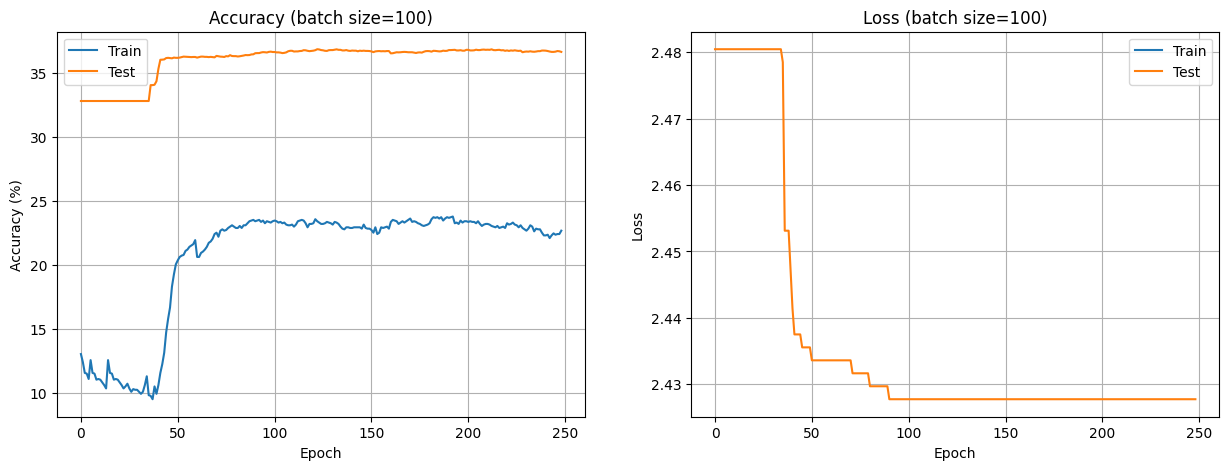

best loss on test dataset = 2.4277
best loss on train dataset = inf
best accuracy on test dataset = 36.64078772959667%
train time = 685.0907182693481


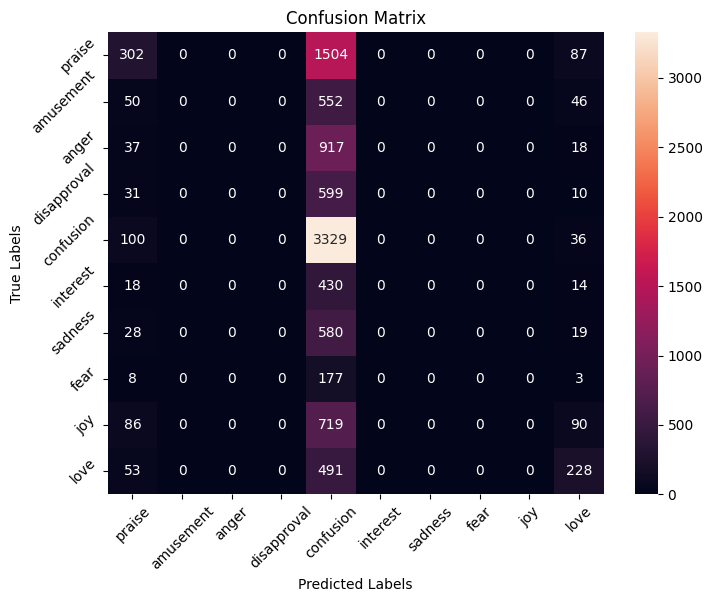

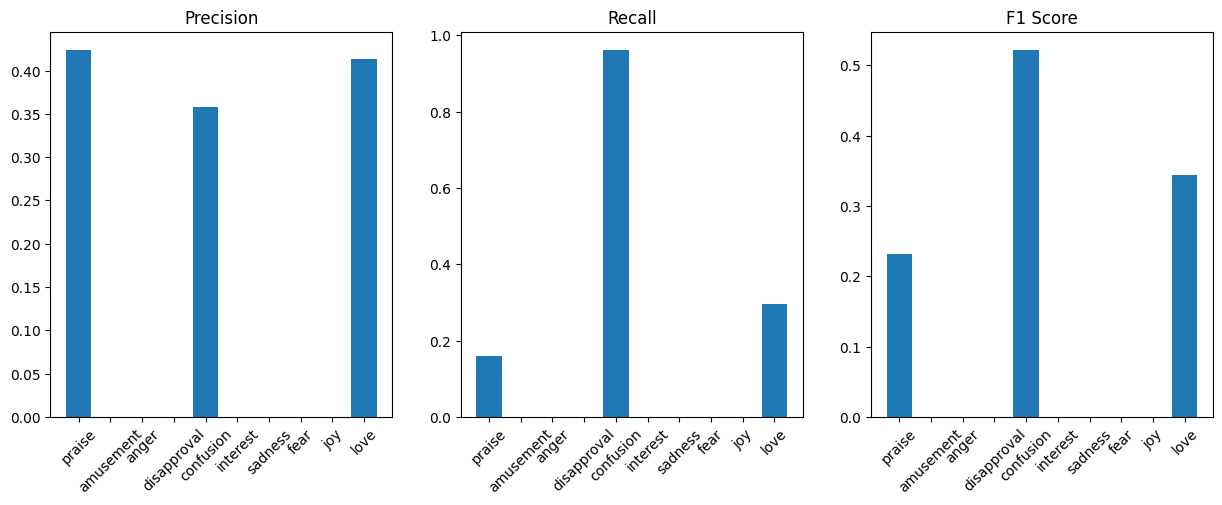

In [34]:
top_level_plot(model)

## Model 3

Dataset shape: (184_900, 1000)

- top 5000 words
- Removed all zero rows
- Apply class weights to remove imbalance

In [35]:
MODEL_PATH = BASE_PATH + 'models/nlp_model3.pt'
model = NeuralNetwork1.load(MODEL_PATH)
if not model:
    model = NeuralNetwork1()
model = model.to(device)
model = model.type(torch.float16)

Loading from disc: drive/MyDrive/NLP_project/models/nlp_model3.pt


In [36]:
model

NeuralNetwork1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1000, out_features=666, bias=True)
    (1): ReLU()
    (2): Linear(in_features=666, out_features=333, bias=True)
    (3): ReLU()
    (4): Linear(in_features=333, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [37]:
%%skip
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
top_level_func_training(model,
                        x_train_tensor,
                        y_train_tensor,
                        x_train_batch,
                        y_train_batch,
                        x_test_tensor,
                        y_test_tensor,
                        loss_fn,
                        optimizer,
                        MODEL_PATH,
                        number_epochs=0,
                        patience=50)

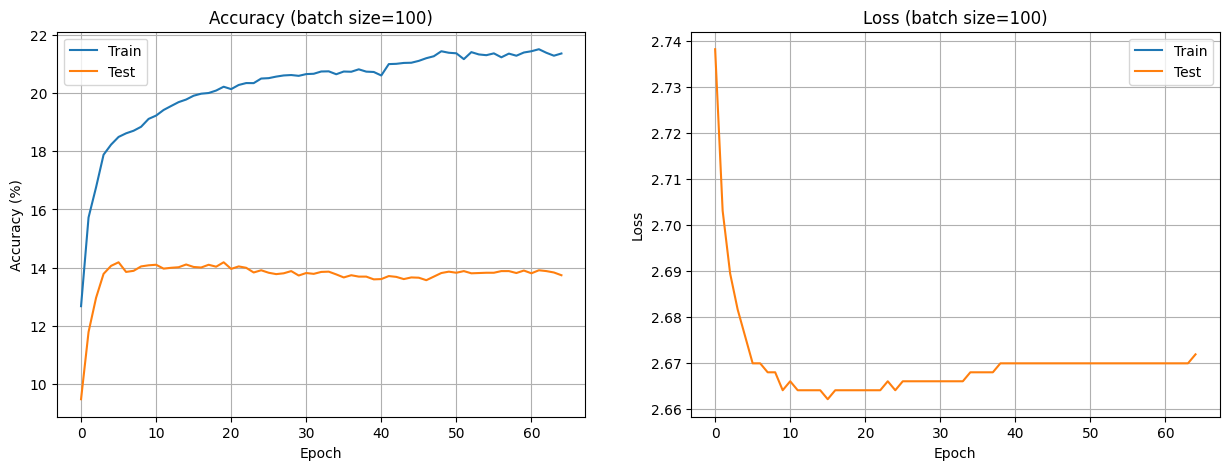

best loss on test dataset = 2.6719
best loss on train dataset = inf
best accuracy on test dataset = 13.737928422647224%
train time = 182.18452501296997


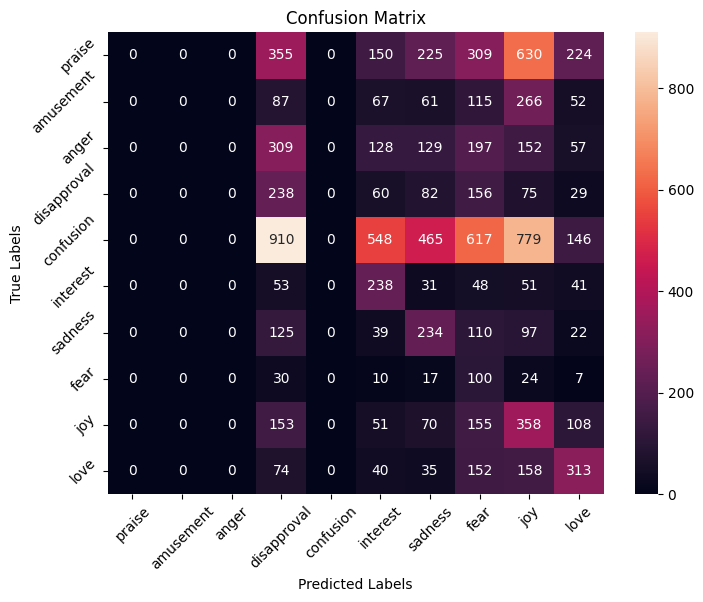

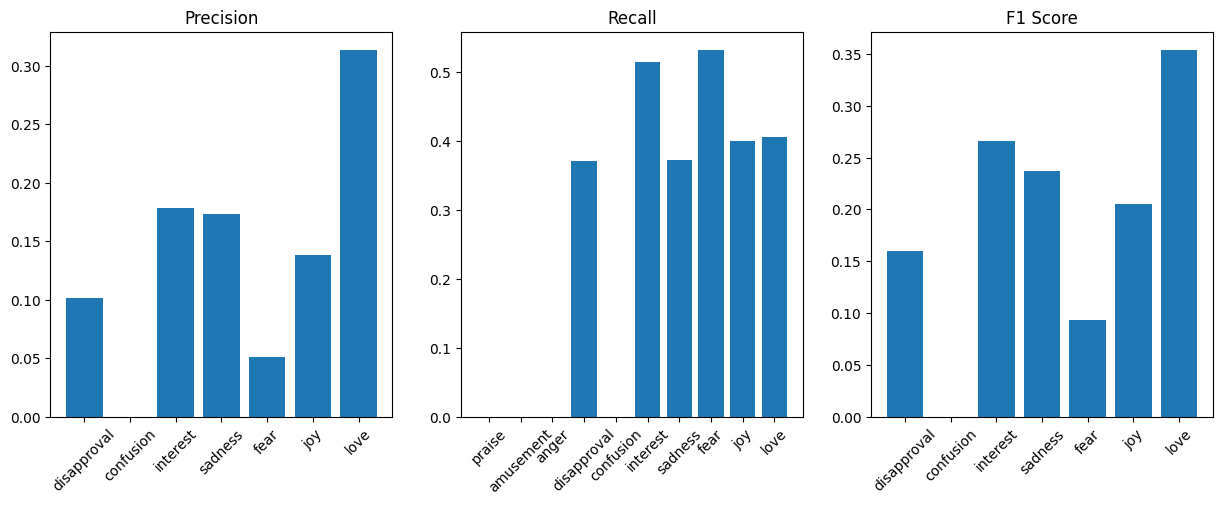

In [38]:
top_level_plot(model)

## Model 4

- 10_000

In [39]:
MODEL_PATH = BASE_PATH + 'models/nlp_model4.pt'
model = NeuralNetwork1.load(MODEL_PATH)
if not model:
    model = NeuralNetwork1()
model = model.to(device)
model = model.type(torch.float16)

Model not found!


In [40]:
model

NeuralNetwork1(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=10000, out_features=6666, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6666, out_features=3333, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3333, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [45]:
%%skip
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
top_level_func_training(model,
                        x_train_tensor,
                        y_train_tensor,
                        x_train_batch,
                        y_train_batch,
                        x_test_tensor,
                        y_test_tensor,
                        loss_fn,
                        optimizer,
                        MODEL_PATH,
                        number_epochs=0,
                        patience=100)

  0%|          | 0/200 [00:00<?, ?it/s]

Early stopping...


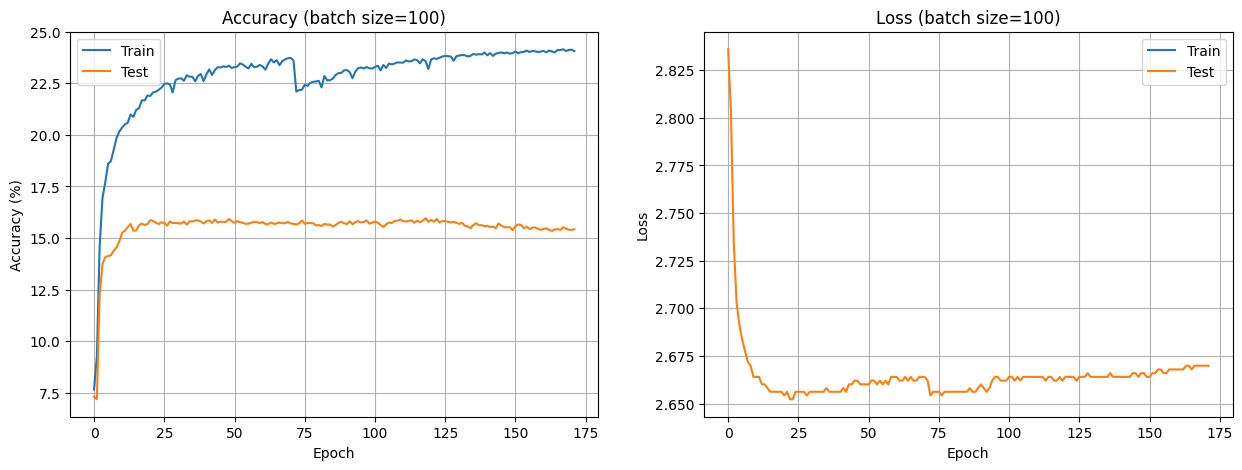

best loss on test dataset = 2.6699
best loss on train dataset = inf
best accuracy on test dataset = 15.42321530013255%
train time = 3699.4268004894257


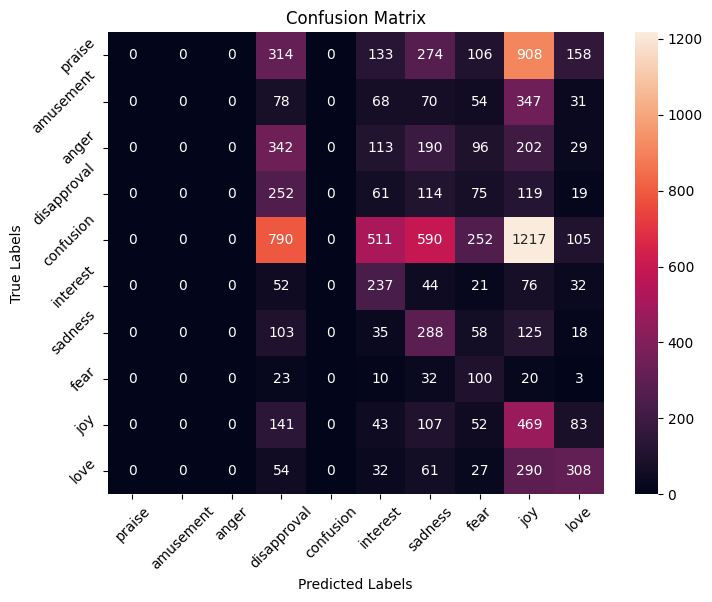

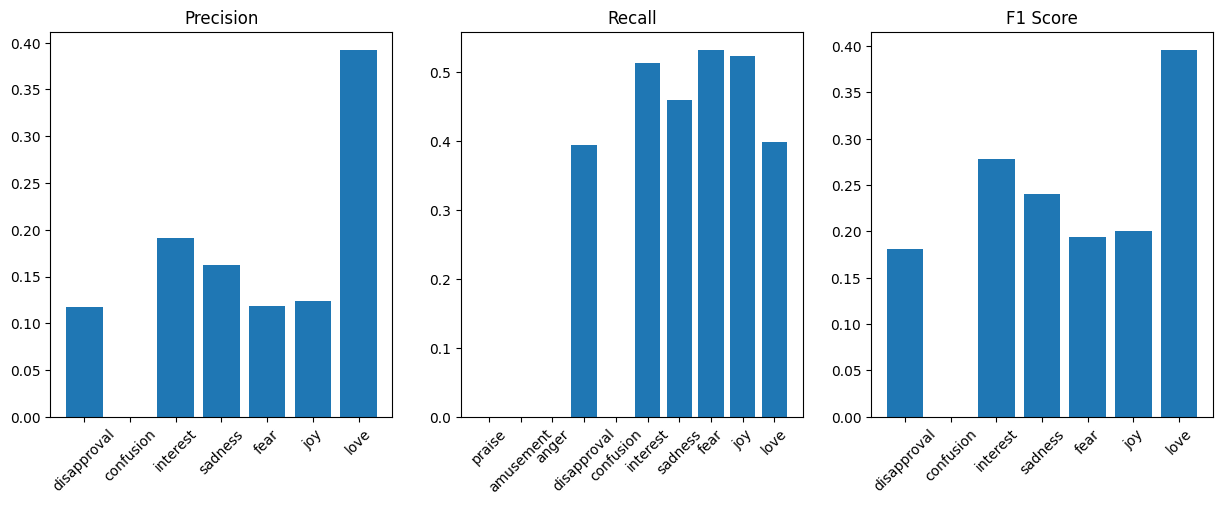

In [46]:
top_level_plot(model)